In [95]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
tfk=tf.keras
tfkl=tf.keras.layers
tfd=tfp.distributions
tfb=tfp.bijectors
tfl=tfp.layers
import matplotlib.pyplot as plt
import precession
import random
random.seed(5)
tf.random.set_seed(5)
import math
import scipy

import re
import corner

In [10]:
x=pd.read_csv('1e5_samples.csv').iloc[:,0:6]
c=pd.read_csv('1e5_samples.csv').iloc[:,6]
x=x.to_numpy()
c=c.to_numpy()
n=x.shape[0]


In [11]:
# while True:
#     c=[]
#     x=[]
#     n=int(1e4)
#     for i in range(0,n):
#         q=np.random.uniform(0,1)
#         chi1=np.random.uniform(0,1)
#         chi2=np.random.uniform(0,1)
#         theta1=np.random.uniform(0,np.pi)
#         theta2=np.random.uniform(0,np.pi)
#         delta_phi=np.random.uniform(0,2*np.pi)
#         x.append([q,chi1,chi2, theta1, theta2, delta_phi])
#         #Mfin=precession.finalmass(0 if chi1>0 else np.pi,0 if chi2>0 else np.pi,0,q,precession.get_fixed(q,abs(chi1),abs(chi2))[3],precession.get_fixed(q,abs(chi1),abs(chi2))[4])
#         chifin=precession.finalspin(theta1,theta2,delta_phi,q,precession.get_fixed(q,abs(chi1),abs(chi2))[3],precession.get_fixed(q,abs(chi1),abs(chi2))[4])
#         #kick=precession.finalkick(0 if chi1>0 else np.pi,0 if chi2>0 else np.pi,0,q,precession.get_fixed(q,abs(chi1),abs(chi2))[3],precession.get_fixed(q,abs(chi1),abs(chi2))[4])
#         c.append([chifin])

#     c=np.array(c,dtype='float32').reshape((-1,1))
#     x=np.array(x,dtype='float32').reshape((-1,6))
    
#     if np.isfinite(c).sum()==n:
#         break
# # data=np.hstack(((x,y)))
# # data.shape
# #y[:,2]=np.log10(y[:,2])
# #y[:,2]=(y[:,2]-np.min(y[:,2]))/(np.max(y[:,2])-np.min(y[:,2]))

# print(x.shape)
# print(c.shape)



(10000, 6)
(10000, 1)


In [12]:
np.isfinite(c).sum()

10000

In [13]:
ndim=6
n=x.shape[0]
bijects=[]

bs=[tfb.Chain([tfb.Scale(scale=.5), tfb.Shift(1.), tfb.Tanh()]),tfb.Chain([tfb.Scale(scale=np.pi/2),tfb.Shift(1.), tfb.Tanh()]), tfb.Chain([tfb.Scale(scale=np.pi), tfb.Shift(1.) , tfb.Tanh()])]
blockwise=tfb.Blockwise(bs, block_sizes=[3,2,1])
bijects.append(blockwise)


l2=tf.keras.regularizers.l2(l2=0.01)
# Density estimation with MADE.
for i in range(10):
  made = tfb.AutoregressiveNetwork(
    params=2,
    hidden_units=[1024],
    event_shape=(ndim,),
    conditional=True,
    conditional_event_shape=(1,),
    #conditional_input_layers='first_layer',
    activation='leaky_relu',
    kernel_initializer='RandomNormal',
    bias_initializer='RandomNormal',
    kernel_regularizer=l2
    # bias_regularizer='L2'
  )
  masked_made=tfb.MaskedAutoregressiveFlow(made, name=f'maf{i}')
  bijects.append(masked_made)
  print(masked_made)

  permute=tfb.Permute(list(reversed(range(ndim))))
  bijects.append(permute)

final_bijector=tfb.Chain(bijects)


def make_bijector_kwargs(bijector, name_to_kwargs):
  if hasattr(bijector, 'bijectors'):
      return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
  else:
      for name_regex, kwargs in name_to_kwargs.items():
          if re.match(name_regex, bijector.name):
              return kwargs
  return {}



distribution = tfd.TransformedDistribution(
distribution=tfd.Sample(tfd.Normal(0., 1.), sample_shape=[ndim]),
bijector=final_bijector)

# Construct and fit model.
x_ = tfkl.Input(shape=(ndim,), dtype=tf.float32)
c_ = tfkl.Input(shape=(1,), dtype=tf.float32)


log_prob_ = distribution.log_prob(x_,
bijector_kwargs=make_bijector_kwargs(distribution.bijector, {'maf.': {'conditional_input': c_}}))

model = tfk.Model([x_, c_], log_prob_)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              loss=lambda _, log_prob: -log_prob)

# es=tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                 min_delta=0.05, 
#                                 patience=10, 
#                                 verbose=0, 
#                                 mode='min', 
#                                 baseline=None, 
#                                 restore_best_weights=False)

def schedule(epoch, lr):
    if epoch<40:
        lr=1e-3
    elif epoch<70:
        lr=5e-4
    else:
        lr=1e-4
    return lr


lrs=tf.keras.callbacks.LearningRateScheduler(
    schedule, verbose=False
)


mc = tf.keras.callbacks.ModelCheckpoint(
        filepath='/data/sneogi/maf5.hdf5',
        monitor='val_loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True,
        save_freq='epoch',
        verbose=1,
        )


tfp.bijectors.MaskedAutoregressiveFlow("maf0", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf1", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf2", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf3", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf4", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf5", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf6", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf7", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf8", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf9", batch_shape=[], min_event_ndims=1)


In [14]:
batch_size = 32
history= model.fit(x=[x, c],
          y=np.zeros((n, 0), dtype=np.float32),
          batch_size=batch_size,
          epochs=300,
          steps_per_epoch=n // batch_size,
          shuffle=True,
          verbose=True,
          validation_split=0.2,
          callbacks=[lrs, mc])

Epoch 1/300
309/312 [============================>.] - ETA: 0s - loss: 5.5410
Epoch 1: val_loss improved from inf to 4.55308, saving model to ./maf5.hdf5
312/312 [==============================] - 11s 20ms/step - loss: 5.5320 - val_loss: 4.5531 - lr: 0.0010
Epoch 2/300
309/312 [============================>.] - ETA: 0s - loss: 3.9299
Epoch 2: val_loss improved from 4.55308 to 3.67941, saving model to ./maf5.hdf5
312/312 [==============================] - 6s 19ms/step - loss: 3.9254 - val_loss: 3.6794 - lr: 0.0010
Epoch 3/300
310/312 [============================>.] - ETA: 0s - loss: 3.3118
Epoch 3: val_loss improved from 3.67941 to 3.22894, saving model to ./maf5.hdf5
312/312 [==============================] - 5s 17ms/step - loss: 3.3095 - val_loss: 3.2289 - lr: 0.0010
Epoch 4/300
309/312 [============================>.] - ETA: 0s - loss: 3.0066
Epoch 4: val_loss improved from 3.22894 to 2.84039, saving model to ./maf5.hdf5
312/312 [==============================] - 5s 15ms/step - loss

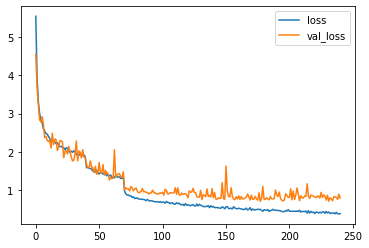

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [57]:
samples = distribution.sample(
    int(1e4),
    bijector_kwargs=make_bijector_kwargs(
        distribution.bijector,
        {'maf.': {'conditional_input': np.array([0.62])}}),
        ).numpy()
samples.shape




(10000, 6)

In [79]:
np.isfinite(samples).sum(axis=0)
np.isfinite(x).sum(axis=0)

array([10000, 10000, 10000, 10000, 10000, 10000])

In [80]:
n_nan=np.isnan(samples).sum()//6
samples.shape[0]
print(n_nan)

7


In [81]:
samples_1, samples_r=np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32), np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32)
for i in range(samples.shape[1]):
    samples_1=samples[np.isfinite(samples[:,i])][:,i].reshape(-1,1)
    samples_r=np.hstack([samples_r, samples_1])
    


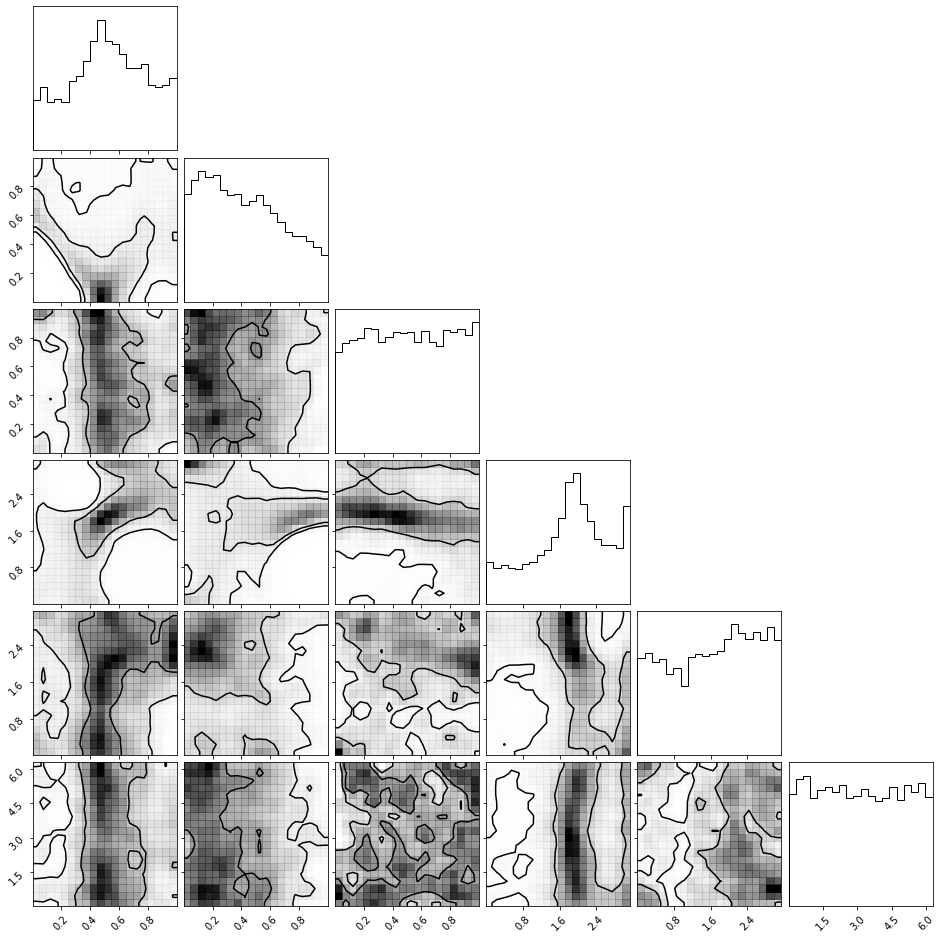

In [94]:
corner.corner(
    samples_r[:,1:], plot_datapoints=False, plot_density=True,
    levels=[.5,.9], smooth=.8,
    );
